In [1]:
import torch
from FisheyeSeg_master.data.CityScape import CityScape
from FisheyeSeg_master.data.FishEyeGenerator import FishEyeGenerator
from torchvision.transforms import ToTensor, ColorJitter, Normalize
from PIL import Image
import random
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
from FisheyeSeg_master.config import DefaultConfig
from FisheyeSeg_master.models.ERFPSPNet import ERFPSPNet
from FisheyeSeg_master.models.SwiftNet import SwiftNet, resnet18
import torch.nn.functional as F
from torch import nn
import math
import segmentation_models_pytorch as smp
from FisheyeSeg_master.test import label2color
import time
from torch.utils.tensorboard import SummaryWriter
import torchvision
import os
import sys
from FisheyeSeg_master.loss import FocalLoss2d, CrossEntropyLoss2d
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor, Normalize
import pandas as pd
from torchvision.transforms import ToPILImage


def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

Config = DefaultConfig()
MyDevice = get_default_device()
MyCPU = torch.device('cpu')

d:\Users\admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 논문 test 코드 다 합치기

d:\Users\admin\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


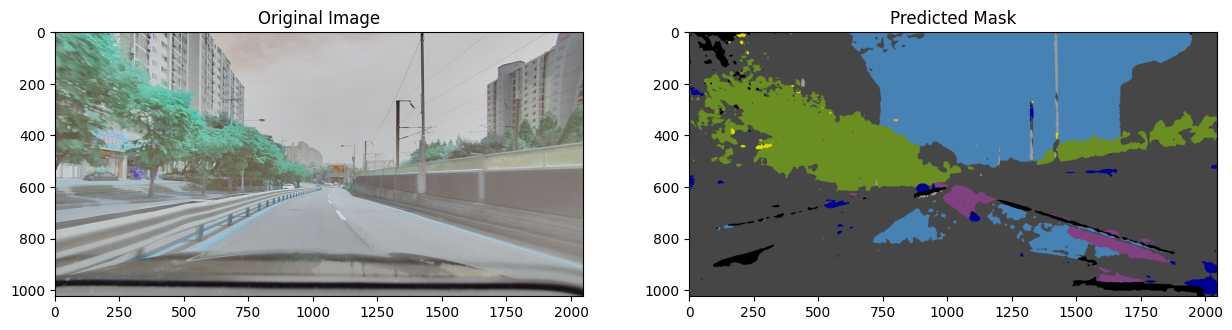

KeyboardInterrupt: 

In [2]:
COLOR_MAP = {5:[250, 168, 40], 6:[220, 220, 0], 10:[255,0,0], 11:[0,0,144], 
        0:[127, 65, 128],1:[249, 34, 233], 2:[70, 70, 70], 3:[189, 153, 153], 4:[154, 154, 154],
        7:[106, 142, 34], 8:[70,130,180], 9:[222, 19, 62], 12:[0,0,0]}

imgs = sorted([os.path.join("./train_source_image/", img) for img in os.listdir("./train_source_image/")])
resnet = resnet18(pretrained=True).to(torch.device('cuda'))
model = SwiftNet(resnet, num_classes=13)
model = model.to(torch.device('cuda'))
checkpoint = torch.load("./checkpoints/addxshift07/ckpt_0.pth")
# print("Load",Config.ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to(torch.device('cuda'))
for img in imgs:
    images = cv2.imread(img)
    image = cv2.imread(img)
    
    # images = images[:,:,(2,1,0)]
    images = images.astype(np.uint8)
    images = (images * 255).astype(np.uint8)
    images = ToTensor()(images)
    
    images = images.to(torch.device('cuda'))
    images.unsqueeze_(0)
    outputs = model(images)
    predict = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8)[0].numpy()
    # label = label2color(predict)
    shape = predict.shape
    label = np.zeros((shape[0],shape[1],3), dtype=np.uint8)
    for i in range(shape[0]):
        for j in range(shape[1]):
            label[i,j] = COLOR_MAP[predict[i,j]]
    # label = label[:,:,(2,1,0)]

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    # plt.imshow(images.squeeze(0).cpu().numpy().transpose(1,2,0))
    plt.imshow(image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(label) # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
    plt.title("Predicted Mask")
    
    plt.show()

# 논문+smp

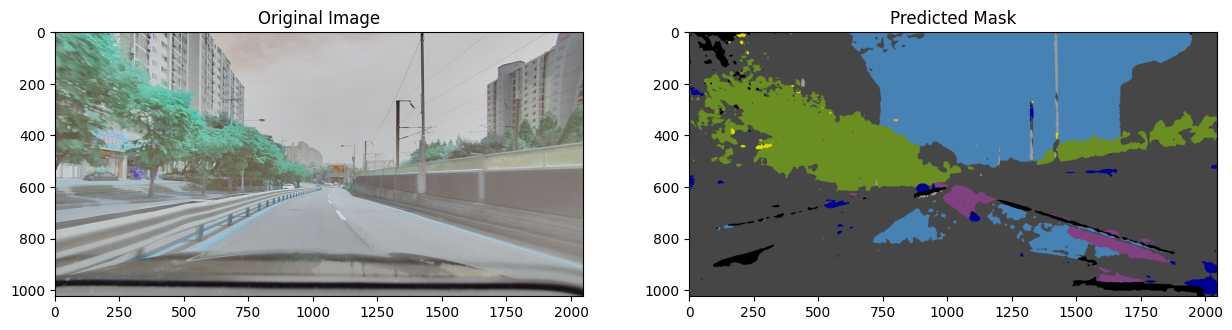

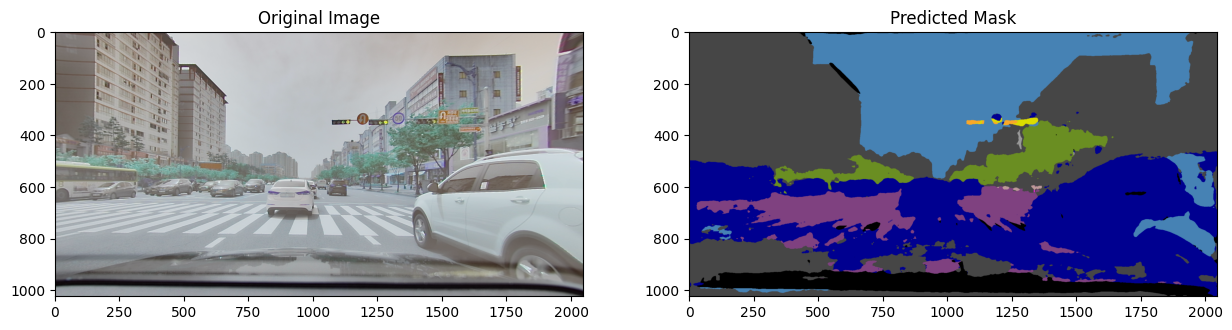

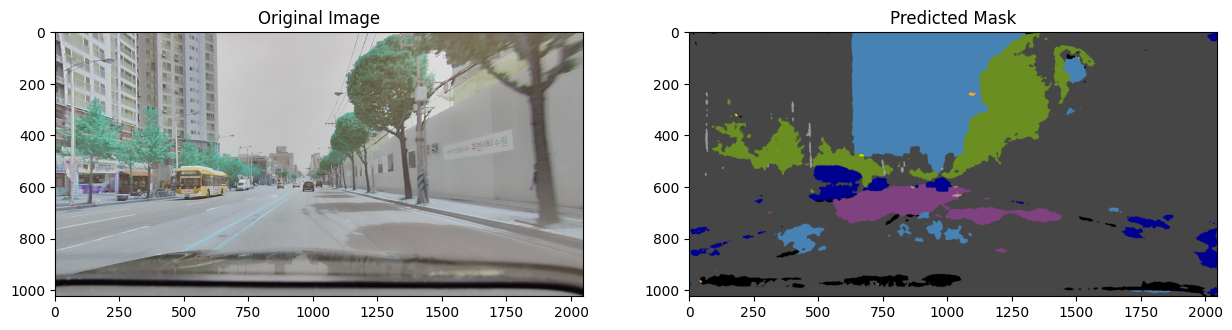

KeyboardInterrupt: 

In [25]:
COLOR_MAP = {5:[250, 168, 40], 6:[220, 220, 0], 10:[255,0,0], 11:[0,0,144], 
        0:[127, 65, 128],1:[249, 34, 233], 2:[70, 70, 70], 3:[189, 153, 153], 4:[154, 154, 154],
        7:[106, 142, 34], 8:[70,130,180], 9:[222, 19, 62], 12:[0,0,0]}

imgs = sorted([os.path.join("./train_source_image/", img) for img in os.listdir("./train_source_image/")])
resnet = resnet18(pretrained=True).to(torch.device('cuda'))
model = SwiftNet(resnet, num_classes=13)
model = model.to(torch.device('cuda'))
checkpoint = torch.load("./checkpoints/addxshift07/ckpt_0.pth")
# print("Load",Config.ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to(torch.device('cuda'))
# print(model)
for img in imgs:
    images = cv2.imread(img)
    # print(images)
    image = cv2.imread(img)

    images = images.astype(np.uint8)
    images = (images * 255).astype(np.uint8)
    images = ToTensor()(images)
    # print("images",images)
    images = images.to(torch.device('cuda'))
    images.unsqueeze_(0)
    outputs = model(images)
    # print(outputs)

    # # .size() 메서드를 사용하여 텐서의 크기 출력
    # size = outputs.size()
    # print("텐서의 크기 (size()):", size)

    # # .shape 속성을 사용하여 텐서의 크기 출력
    # shape = outputs.shape
    # print("텐서의 크기 (shape):", shape)


    predict = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8)[0].numpy()
    # print("predict",predict)
    # print("predict",predict,predict.type)
    shape = predict.shape
    label = np.zeros((shape[0],shape[1],3), dtype=np.uint8)
    for i in range(shape[0]):
        for j in range(shape[1]):
            label[i,j] = COLOR_MAP[predict[i,j]]
    # label = label[:,:]

    # images = images.squeeze(0).cpu().numpy()  # 이미지를 NumPy 배열로 변환
    # images = np.transpose(images, (1, 2, 0))  # (3, 1080, 1920)를 (1080, 1920, 3)으로 변경

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
     
    plt.subplot(1, 2, 2)
    plt.imshow(label) # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
    plt.title("Predicted Mask")
    
    plt.show()

tensor([[[[-0.7770, -0.7770, -0.8149,  ..., -1.0083, -0.9675, -0.9675],
          [-0.7770, -0.7770, -0.8149,  ..., -1.0083, -0.9675, -0.9675],
          [-0.8143, -0.8143, -0.8541,  ..., -1.0376, -0.9924, -0.9924],
          ...,
          [-0.1726, -0.1726, -0.1959,  ..., -0.2427, -0.2331, -0.2331],
          [-0.1250, -0.1250, -0.1446,  ..., -0.2120, -0.2102, -0.2102],
          [-0.1250, -0.1250, -0.1446,  ..., -0.2120, -0.2102, -0.2102]],

         [[-1.3457, -1.3457, -1.4489,  ..., -1.0176, -0.9579, -0.9579],
          [-1.3457, -1.3457, -1.4489,  ..., -1.0176, -0.9579, -0.9579],
          [-1.3926, -1.3926, -1.4991,  ..., -1.1017, -1.0336, -1.0336],
          ...,
          [-0.9169, -0.9169, -0.9451,  ..., -1.4270, -1.3255, -1.3255],
          [-0.8783, -0.8783, -0.9000,  ..., -1.3246, -1.2269, -1.2269],
          [-0.8783, -0.8783, -0.9000,  ..., -1.3246, -1.2269, -1.2269]],

         [[ 0.4602,  0.4602,  0.4876,  ...,  0.5545,  0.5458,  0.5458],
          [ 0.4602,  0.4602,  

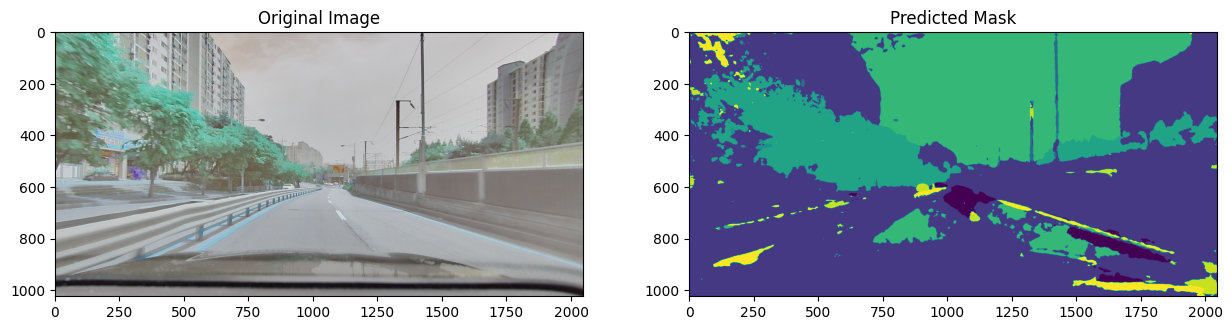

KeyboardInterrupt: 

In [24]:
COLOR_MAP = {5:[250, 168, 40], 6:[220, 220, 0], 10:[255,0,0], 11:[0,0,144], 
        0:[127, 65, 128],1:[249, 34, 233], 2:[70, 70, 70], 3:[189, 153, 153], 4:[154, 154, 154],
        7:[106, 142, 34], 8:[70,130,180], 9:[222, 19, 62], 12:[0,0,0]}

imgs = sorted([os.path.join("./train_source_image/", img) for img in os.listdir("./train_source_image/")])
resnet = resnet18(pretrained=True).to(torch.device('cuda'))
model = SwiftNet(resnet, num_classes=13)
model = model.to(torch.device('cuda'))
checkpoint = torch.load("./checkpoints/addxshift07/ckpt_0.pth")
# print("Load",Config.ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to(torch.device('cuda'))
# print(model)
for img in imgs:
    images = cv2.imread(img)
    # print(images,images.shape)
    image = cv2.imread(img)

    images = images.astype(np.uint8)
    # print("astype img ",images)
    images = (images * 255).astype(np.uint8)
    # print(images,images.shape)

    images = ToTensor()(images)
    # print("images",images)
    images = images.to(torch.device('cuda'))
    images.unsqueeze_(0)
    # print(images, images.size)
    outputs = model(images)
    # print(outputs)
    print(outputs)
    # # .size() 메서드를 사용하여 텐서의 크기 출력
    # size = outputs.size()
    # print("텐서의 크기 (size()):", size)

    # # .shape 속성을 사용하여 텐서의 크기 출력
    # shape = outputs.shape
    # print("텐서의 크기 (shape):", shape)


    predict = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8)[0].numpy()
    # print("predict",predict)
    # print("predict",predict,predict.type)
    # shape = predict.shape
    # label = np.zeros((shape[0],shape[1],3), dtype=np.uint8)
    # for i in range(shape[0]):
    #     for j in range(shape[1]):
    #         label[i,j] = COLOR_MAP[predict[i,j]]
    # label = label[:,:]

    # images = images.squeeze(0).cpu().numpy()  # 이미지를 NumPy 배열로 변환
    # images = np.transpose(images, (1, 2, 0))  # (3, 1080, 1920)를 (1080, 1920, 3)으로 변경
    # print(predict.shape)
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
     
    plt.subplot(1, 2, 2)
    plt.imshow(predict) # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
    plt.title("Predicted Mask")
    
    plt.show()